In [6]:
import os
import pandas as pd
import json

### vauth

In [ ]:
from google.colab import auth
auth.authenticate_user()


# preprosessing

## extract features from files and make a dataframe

In [9]:
#help function to import data as dataframes
def import_to_df(folder): 
  
# Loop through all the files in the folder
  for filename in os.listdir(folder):
      data = []
      errors = 0
      if ("data" not in filename):
          continue
      file_path = os.path.join(folder, filename)
      # Load the JSON file
      with open(file_path) as f:
          #print(file_path)
          # Extract the relevant features from each log entry
          for line in f:
              try:
                  entry = json.loads(line)
                  # Extract the relevant features from the entry and add them to the data list
                  features = {'latency': entry['httpRequest']['latency'],
                              'requestSize': entry['httpRequest']['requestSize'],
                              'requestMethod': entry['httpRequest']['requestMethod'],
                              'responseSize': entry['httpRequest']['responseSize'],
                              'requestUrl': entry['httpRequest']['requestUrl'],
                              'status': entry['httpRequest']['status'],
                              'source_app': entry['labels']['source_app'],
                              'timestamp': entry['timestamp']}
                  data.append(features)
              except json.JSONDecodeError:
                  # Handle JSONDecodeError and continue to the next line
                  errors += 1
                  print(f"Error decoding JSON in file {file_path}: {line}")
                  continue
              except KeyError:
                  # Error and continue to the next line
                  errors += 1
                  print(f"KEY error in file {file_path}: {line}")
                  continue


  # Convert the list of dictionaries into a DataFrame
  print("Number of errors: " + str(errors))
  df = pd.DataFrame(data)
  print(df.head())
  return df


## import train

In [ ]:
train_df = import_to_df("/content/normal");

train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], utc=True)
# set timestamp as the index
train_df.set_index('timestamp', inplace=True)
# Sort the DataFrame by the index 
train_df = train_df.sort_index()

train_dforiginal = train_df.copy()

#catergorize latency
train_df['latency'] = (train_df['latency'] < 0.1).astype(int)


## import test

In [17]:
test_df = import_to_df("/content/anomaly");

# set timestamp as the index

test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], utc=True)
test_df.set_index('timestamp', inplace=True)

# Sort the DataFrame by the index 
test_df = test_df.sort_index()

test_dforiginal = test_df.copy()

#catergorize latency
test_df['latency'] = (test_df['latency'] < 0.1).astype(int)


KEY error in file /content/anomaly/data-000000000068: {"logName":"projects/arstiladippa/logs/server-accesslog-stackdriver","resource":{"type":"k8s_container","labels":{"container_name":"server","location":"europe-north1","namespace_name":"default","cluster_name":"onlineboutique","pod_name":"adservice-555649568c-7xs8v","project_id":"arstiladippa"}},"timestamp":"2023-04-21 23:25:58.734769 UTC","receiveTimestamp":"2023-04-21 23:26:00.178806 UTC","severity":"INFO","insertId":"17ujnq8f3wjkxn","httpRequest":{"requestMethod":"POST","requestUrl":"http://adservice:9555/hipstershop.AdService/GetAds","requestSize":"694","userAgent":"grpc-go/1.53.0","remoteIp":"10.68.129.200:58810","serverIp":"10.68.129.70:9555","latency":0.000397674,"protocol":"grpc"},"labels":{"source_workload":"frontend","request_id":"160447fa-74c4-4f16-8108-e655045767bb","destination_namespace":"default","response_flag":"-","destination_service_host":"adservice.default.svc.cluster.local","log_sampled":"false","source_name":"fr

In [40]:
print(train_df.columns, len(train_df))
print(test_df.columns, len(test_df))


Index(['key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7',
       'key_8', 'key_9',
       ...
       'key_336', 'key_337', 'key_338', 'key_339', 'key_340', 'key_341',
       'key_342', 'key_343', 'key_344', 'key_345'],
      dtype='object', length=346) 52912
Index(['key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7',
       'key_8', 'key_9',
       ...
       'key_336', 'key_337', 'key_338', 'key_339', 'key_340', 'key_341',
       'key_342', 'key_343', 'key_344', 'key_345'],
      dtype='object', length=346) 49904


## backup

In [ ]:
# in case of error
train_df = train_dforiginal
test_df = test_dforiginal

print(train_df.head)
print(test_df.head)

<bound method NDFrame.head of                                  latency requestSize requestMethod  \
timestamp                                                            
2023-04-15 16:50:22.241541 UTC  0.002163         723          POST   
2023-04-15 16:50:22.272519 UTC  0.002794         739          POST   
2023-04-15 16:50:22.283803 UTC  0.002220         723          POST   
2023-04-15 16:50:22.788723 UTC  0.002255         723          POST   
2023-04-15 16:50:23.454963 UTC  0.079178         723          POST   
...                                  ...         ...           ...   
2023-04-15 17:22:38.664003 UTC  0.001816         717          POST   
2023-04-15 17:22:38.668368 UTC  0.000670         730          POST   
2023-04-15 17:22:38.670605 UTC  0.001749         717          POST   
2023-04-15 17:22:38.673977 UTC  0.000728         730          POST   
2023-04-15 17:22:38.676006 UTC  0.001259         717          POST   

                               responseSize  \
timestamp   

## create keyes and dummies

In [19]:
# concatenate the dataframes
df_concat = pd.concat([test_df, train_df], axis=0)


# create keys for both dataframes
df_concat['key'] = df_concat.groupby(['latency', 'requestSize', 'requestMethod', 'responseSize',
       'requestUrl', 'status', 'source_app'], dropna=False).ngroup()

# get dummies for the 'key' column
df_concat=df_concat[['key']]
df_concat = pd.get_dummies(df_concat, columns=['key'])

#print(df_concat.head())

# split back into original dataframes
test_df = df_concat.iloc[:len(test_df), :]
train_df = df_concat.iloc[len(test_df):, :]



In [20]:
print(len(test_df))
print(len(train_df))

49904
52912


In [21]:
test_df.head()

,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,...,key_336,key_337,key_338,key_339,key_340,key_341,key_342,key_343,key_344,key_345
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-04-21 06:40:33.188945+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-21 06:40:33.340075+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-21 06:40:33.343117+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-21 06:40:33.358187+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-21 06:40:33.360701+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# ML

##variables

In [27]:
# lstm autoencoder to recreate a timeseries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
'''
A UDF to convert input data into 3-D
array as required for LSTM network.
'''

def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [36]:
#defaults

timeseries = np.array(train_df.values)
timesteps = 10

X, y = temporalize(X = timeseries, y = np.zeros(len(timeseries)), lookback = timesteps)
n_features = timeseries.shape[1]


X = np.array(X)
X = X.reshape(X.shape[0], timesteps, n_features)

latent_dim = 3
batch_size = 32
epochs = 20

## gpu test

In [24]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## define model

In [39]:
import keras
from keras.models import Sequential
from keras.layers import LSTM

# define the model
with tf.device('/device:GPU:0'):
  model = tf.keras.Sequential()
  model.add(LSTM(128, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
  model.add(LSTM(64, activation='relu', return_sequences=False))
  model.add(RepeatVector(timesteps))
  model.add(LSTM(64, activation='relu', return_sequences=True))
  model.add(LSTM(128, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(n_features)))
  model.compile(optimizer='adam', loss='mse')
  model.summary()
# Write LaTeX table to file
with open('modelsummary.tex', 'w') as f:
    f.write(str(model.summary()))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 10, 128)           243200    
                                                                 
 lstm_33 (LSTM)              (None, 64)                49408     
                                                                 
 repeat_vector_8 (RepeatVect  (None, 10, 64)           0         
 or)                                                             
                                                                 
 lstm_34 (LSTM)              (None, 10, 64)            33024     
                                                                 
 lstm_35 (LSTM)              (None, 10, 128)           98816     
                                                                 
 time_distributed_8 (TimeDis  (None, 10, 346)          44634     
 tributed)                                            

In [ ]:
import tabulate
table = tabulate.tabulate([['Layer (type)', 'Output Shape', 'Param #'],
                           *[(layer.name, layer.output_shape, layer.count_params()) for layer in model.layers]],
                          headers='firstrow', tablefmt='latex_booktabs')
print(table)



### fit

In [41]:
# fit model
with tf.device('/device:GPU:0'):
  #X = X.astype('float32')
  history = model.fit(X, X, epochs=10, batch_size=32, verbose=3, validation_split=0.2)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


### predict train

In [43]:
X_pred = model.predict(X)

1654/1654 [==============================] - 13s 8ms/step


### Predict test

In [52]:
X_test, y = temporalize(X = timeseries, y = np.zeros(len(timeseries)), lookback = timesteps)
n_features = timeseries.shape[1]


X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], timesteps, n_features)

predictions = model.predict(X_test)

1654/1654 [==============================] - 13s 8ms/step


# Classify

In [ ]:
from sklearn.metrics import mean_squared_error
mse_train = []

# Iterate over each sequence in X_test
for i in range(X.shape[0]):
    # Get the current sequence
    sequence = X[i]

    # Calculate the mean squared error for the sequence
    mse = mean_squared_error(X[i], X_pred[i])
    mse_train.append(mse)
    mse_train.append(mse)
 

In [49]:
mse_train[:10]

[0.0024193558,
 0.0024193558,
 0.002869074,
 0.002869074,
 0.0029017546,
 0.0029017546,
 0.0027477816,
 0.0027477816,
 0.0027943514,
 0.0027943514]

### TRESHOLD

In [50]:
# Assuming you have calculated the errors already and stored them in a variable named "errors"
mean_error = np.mean(mse_train)
std_error = np.std(mse_train)

# Set threshold as a certain number of standard deviations from the mean
num_std = 2  # Set number of standard deviations away from mean
threshold = mean_error + num_std * std_error

print(f"Threshold: {threshold}")

Threshold: 0.0023835654137656093


## Run the model on anomalous data

# timeseries testing

In [34]:
timestepslist = [5,10,25,50]
timeseries = np.array(train_df.values)
errors = []
epochs = 10

# Train LSTM autoencoder models for each timestep
for timesteps in timestepslist:
    # Prepare the data with the current timestep
    X_train = []
    X_train, y = temporalize(X= timeseries, y = np.zeros(len(timeseries)), lookback = timesteps)
    n_features = timeseries.shape[1]

    X_train  = np.array(X_train)
    X_train = X_train.reshape(X.shape[0], timesteps, n_features)
    with tf.device('/device:GPU:0'):
      model = tf.keras.Sequential()
      model.add(LSTM(128, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
      model.add(LSTM(64, activation='relu', return_sequences=False))
      model.add(RepeatVector(timesteps))
      model.add(LSTM(64, activation='relu', return_sequences=True))
      model.add(LSTM(128, activation='relu', return_sequences=True))
      model.add(TimeDistributed(Dense(n_features)))
      model.compile(optimizer='adam', loss='mse')
      model.summary()
    # Write LaTeX table to file
    #with open('modelsummary{}.tex'.format(timesteps), 'w') as f:
    #    f.write(model.summary())

    history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, verbose=1)
    
    # Compute the reconstruction error
    X_train_pred = model.predict(X_train)
    train_mse = np.mean(np.power(X_train - X_train_pred, 2), axis=1)
    train_mse = train_mse.reshape((-1,))
    
    # Print the average reconstruction error
    print(f'Timestep = {timesteps}, average reconstruction error = {np.mean(train_mse)}')


      


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 5, 128)            243200    
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 repeat_vector_4 (RepeatVect  (None, 5, 64)            0         
 or)                                                             
                                                                 
 lstm_18 (LSTM)              (None, 5, 64)             33024     
                                                                 
 lstm_19 (LSTM)              (None, 5, 128)            98816     
                                                                 
 time_distributed_4 (TimeDis  (None, 5, 346)           44634     
 tributed)                                            

ValueError: ignored

# result analysis

In [26]:
# Extract important information from train_df and test_df
n_train_samples, n_train_features = train_df.shape
n_test_samples, n_test_features = test_df.shape


# Create a LaTeX table with the extracted information
latex = """
\\begin{table}[ht]
\\centering
\\begin{tabular}{|l|c|c|}
\\hline
\\textbf{Dataset} & \\textbf{Number of Samples} & \\textbf{Number of Features} \\\\
\\hline
Train & %d & %d \\\\
Test & %d & %d \\\\
\\hline
\\end{tabular}
\\caption{Important Information from train\_df and test\_df Datasets}
\\label{tab:dataset-info}
\\end{table}

\\begin{table}[ht]
\\centering
\\begin{tabular}{|l|c|}
\\hline
\\textbf{Parameter} & \\textbf{Value} \\\\
\\hline
Number of Timesteps & %d \\\\
Number of Features & %d \\\\
Latent Dimension & %d \\\\
Batch Size & %d \\\\
\\hline
\\end{tabular}
\\caption{Parameters Used in the LSTM Autoencoder Model}
\\label{tab:model-parameters}
\\end{table}
""" % (n_train_samples, n_train_features, n_test_samples, n_test_features, timesteps, n_features, latent_dim, batch_size)

# Write LaTeX table to file
with open('info.tex', 'w') as f:
    f.write(latex)

In [ ]:
from tabulate import tabulate

# model summary
model_summary = []
model.summary(print_fn=lambda x: model_summary.append(x))
model_summary = '\n'.join(model_summary)

# predicted and actual values
predicted = np.round(yhat, 3)
actual = np.round(X, 3)

# create table
table = [
    ['Model Summary', model_summary],
    ['Predicted Values', predicted],
    ['Actual Values', actual]
]

# convert table to LaTeX format
latex_table = tabulate(table, headers=['Variable', 'Value'], tablefmt='latex')

# print LaTeX table
print(latex_table)


\begin{tabular}{ll}
\hline
 Variable         & Value   \\
\hline
 Model Summary    & Model: "sequential"
\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_
 Layer (type)                Output Shape              Param \#   
 lstm (LSTM)                 (None, 10, 128)           154624    
                                                                 
 lstm\_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat\_vector (RepeatVector  (None, 10, 64)           0         
 )                                                               
                                                                 
 lstm\_2 (LSTM)               (None, 10, 64)            33024     
                                                                 
 lstm\_3 (LSTM)               (None, 10, 128)           98816     
                                 

In [ ]:
# Reshape X and yhat to 2D arrays
X_2d = X.reshape(X.shape[0]*timesteps, n_features)
yhat_2d = yhat.reshape(X.shape[0]*timesteps, n_features)

In [ ]:
# Calculate mean squared error
mse = mean_squared_error(X_2d, yhat_2d)
print("MSE: ", mse)

MSE:  0.0033856726


In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(X_2d, yhat_2d)
print("R2 score: ", r2)

R2 score:  0.06690389884976325


# legacy

In [ ]:
data_train = []
errors_train = 0

for file in uploaded_test :
    for line in file:
      try:
          entry = json.loads(line)
          features = {'latency': entry['httpRequest']['latency'],
                      'requestSize': entry['httpRequest']['requestSize'],
                      'requestMethod': entry['httpRequest']['requestMethod'],
                      'responseSize': entry['httpRequest']['responseSize'],
                      'requestUrl': entry['httpRequest']['requestUrl'],
                      'status': entry['httpRequest']['status'],
                      'source_app': entry['labels']['source_app'],
                      'timestamp': entry['timestamp']}          
          # Extract the relevant features from the entry and add them to the data list
          data_train.append(features)
      except json.JSONDecodeError:
          # Handle JSONDecodeError and continue to the next line
          errors_train += 1
          # print(f"Error decoding JSON in file {file_path}: {line}")
          continue

# Convert the list of dictionaries into a DataFrame
print("Number of errors: " + str(errors_train))
df_train = pd.DataFrame(data_train)
df_train.head()

In [ ]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
# configure tensorflow to use GPU

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.9  # limit the GPU memory used to 90%
sess = tf.compat.v1.Session(config=config)
set_session(sess)

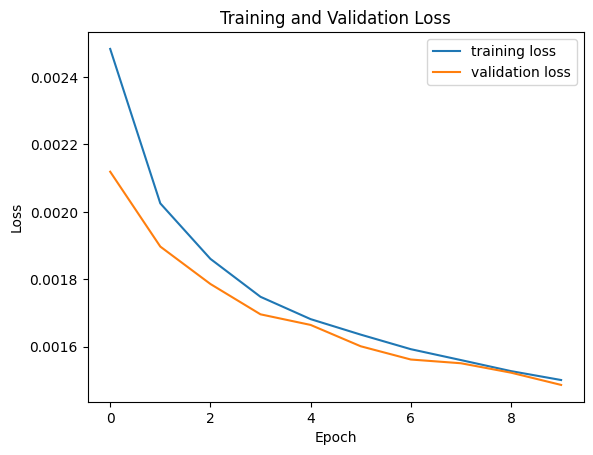

In [ ]:
import matplotlib.pyplot as plt
# plot training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Create Keys

In [ ]:
#create keys for unique rows

df['key'] = df.groupby(['latency', 'requestSize', 'requestMethod', 'responseSize',
       'requestUrl', 'status', 'source_app']).ngroup()

In [ ]:
#latex

latex_table = df.head().style.to_latex()

# print latex table
print(latex_table)

\begin{tabular}{lrllllllr}
 & latency & requestSize & requestMethod & responseSize & requestUrl & status & source_app & key \\
timestamp &  &  &  &  &  &  &  &  \\
2023-04-15 08:26:58.215025 UTC & 1 & 730 & POST & 1757 & http://productcatalogservice:3550/hipstershop.ProductCatalogService/GetProduct & 200 & frontend & 231 \\
2023-04-15 08:26:58.216662 UTC & 1 & 730 & POST & 1695 & http://productcatalogservice:3550/hipstershop.ProductCatalogService/GetProduct & 200 & frontend & 217 \\
2023-04-15 08:26:58.354216 UTC & 1 & 730 & POST & 1747 & http://productcatalogservice:3550/hipstershop.ProductCatalogService/GetProduct & 200 & frontend & 229 \\
2023-04-15 08:26:58.356309 UTC & 1 & 730 & POST & 1695 & http://productcatalogservice:3550/hipstershop.ProductCatalogService/GetProduct & 200 & frontend & 217 \\
2023-04-15 08:26:58.361683 UTC & 1 & 730 & POST & 1742 & http://productcatalogservice:3550/hipstershop.ProductCatalogService/GetProduct & 200 & frontend & 227 \\
\end{tabular}



In [ ]:
df=df[['key']]

df = pd.get_dummies(df, columns=['key'])

In [ ]:
df.head()

,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,...,key_377,key_378,key_379,key_380,key_381,key_382,key_383,key_384,key_385,key_386
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-04-15 08:26:58.215025 UTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-15 08:26:58.216662 UTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-15 08:26:58.354216 UTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-15 08:26:58.356309 UTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-15 08:26:58.361683 UTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler


train_size = int(len(df) * 0.95)
train = df[:train_size][df.columns]
test = df[train_size:][df.columns]

In [ ]:
np.argpartition(X[0][0],-1)[-1]

110

In [ ]:
np.argpartition(yhat[0][0],-5)[-5:]

array([ 58,  68, 113,  32,  76])

In [ ]:
#reconstruction cost for the test set


mse = np.mean(np.mean(np.power(X - yhat, 2), axis=1),axis=1)
mse

array([0.00485279, 0.00451607, 0.00409346, ..., 0.00446442, 0.00524236,
       0.00528777], dtype=float32)

# legacy

In [ ]:
# fit model
model.fit(X, X, epochs=5, batch_size=5, verbose=2)
# demonstrate reconstruction
yhat = model.predict(X, verbose=0)
print('---Predicted---')
print(np.round(yhat,3))
print('---Actual---')
print(np.round(X, 3))

Epoch 1/5
998/998 - 41s - loss: 0.0049 - 41s/epoch - 41ms/step
Epoch 2/5
998/998 - 32s - loss: 0.0043 - 32s/epoch - 32ms/step
Epoch 3/5
998/998 - 32s - loss: 0.0039 - 32s/epoch - 32ms/step
Epoch 4/5
998/998 - 32s - loss: 0.0037 - 32s/epoch - 32ms/step
Epoch 5/5
998/998 - 33s - loss: 0.0035 - 33s/epoch - 33ms/step
---Predicted---
[[[-0.     0.005  0.008 ...  0.001  0.003  0.001]
  [-0.     0.007  0.014 ...  0.001  0.004  0.002]
  [ 0.     0.006  0.015 ...  0.     0.003  0.002]
  ...
  [ 0.007  0.006  0.006 ...  0.003 -0.001 -0.002]
  [ 0.006  0.011  0.008 ...  0.003  0.001 -0.003]
  [ 0.005  0.017  0.012 ...  0.004  0.004 -0.004]]

 [[ 0.     0.006  0.006 ...  0.001  0.003  0.   ]
  [ 0.     0.01   0.012 ...  0.001  0.004  0.002]
  [ 0.     0.01   0.015 ... -0.001  0.004  0.003]
  ...
  [ 0.005  0.01   0.01  ...  0.002  0.    -0.002]
  [ 0.006  0.013  0.011 ...  0.002  0.002 -0.002]
  [ 0.006  0.015  0.012 ...  0.002  0.004 -0.002]]

 [[ 0.001  0.008  0.008 ...  0.001  0.003  0.   ]
  [

In [ ]:
# bug fixing test piece

import os
import json
import pandas as pd

data = []


# Load the JSON file
with open("train/data-000000000021") as f:
# Extract the relevant features from each log entry
    for line in f:
        entry = json.loads(line)
        # Extract the relevant features from the entry and add them to the data list
        features = {'latency': entry['httpRequest']['latency'],
                    'requestSize': entry['httpRequest']['requestSize'],
                    'requestMethod': entry['httpRequest']['requestMethod'],
                    'responseSize': entry['httpRequest']['responseSize'],
                    'requestUrl': entry['httpRequest']['requestUrl'],
                    'status': entry['httpRequest']['status'],
                    'source_app': entry['labels']['source_app'],
                    'timestamp': entry['timestamp']}
        data.append(features)

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data)
df.head

In [ ]:
folder_path = './train'  # change this to your folder path
data = []
errors = 0

# Loop through all the files in the folder
for filename in os.listdir(folder_path):
    if ("data" not in filename):
        continue
    file_path = os.path.join(folder_path, filename)
    # Load the JSON file
    with open(file_path) as f:
        # Extract the relevant features from each log entry
        for line in f:
            try:
                entry = json.loads(line)
                # Extract the relevant features from the entry and add them to the data list
                features = {'latency': entry['httpRequest']['latency'],
                            'requestSize': entry['httpRequest']['requestSize'],
                            'requestMethod': entry['httpRequest']['requestMethod'],
                            'responseSize': entry['httpRequest']['responseSize'],
                            'requestUrl': entry['httpRequest']['requestUrl'],
                            'status': entry['httpRequest']['status'],
                            'source_app': entry['labels']['source_app'],
                            'timestamp': entry['timestamp']}
                data.append(features)
            except json.JSONDecodeError:
                # Handle JSONDecodeError and continue to the next line
                errors += 1
                # print(f"Error decoding JSON in file {file_path}: {line}")
                continue

# Convert the list of dictionaries into a DataFrame
print("Number of errors: " + str(errors))
df = pd.DataFrame(data)
df.head()

Number of errors: 18


,latency,requestSize,requestMethod,responseSize,requestUrl,status,source_app,timestamp
0,0.001479,712,POST,1778,http://currencyservice:7000/hipstershop.Curren...,200,frontend,2023-04-15 09:29:32.235081 UTC
1,0.002243,712,POST,1778,http://currencyservice:7000/hipstershop.Curren...,200,frontend,2023-04-15 09:29:27.826092 UTC
2,0.001678,717,POST,1626,http://currencyservice:7000/hipstershop.Curren...,200,frontend,2023-04-15 09:29:29.543643 UTC
3,0.001477,717,POST,1626,http://currencyservice:7000/hipstershop.Curren...,200,frontend,2023-04-15 09:29:32.243186 UTC
4,0.001591,712,POST,1778,http://currencyservice:7000/hipstershop.Curren...,200,frontend,2023-04-15 09:29:31.537701 UTC


In [ ]:
#OLD


import json
import pandas as pd


# Load data from JSON file and Convert data to pandas DataFrame
df = pd.read_json('data.json', convert_dates=['timestamp'])


In [ ]:
import keras

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X.shape[1], X.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)

model.compile(loss='mae', optimizer='adam')

IndexError: tuple index out of range

In [ ]:
#from sklearn.preprocessing import MinMaxScaler

# Convert categorical features to one-hot encoded format
#df = pd.get_dummies(df, columns=['requestUrl', 'status', 'source_app','requestMethod'])

# Normalize the numerical features
#scaler = MinMaxScaler()
#df[["latency", "requestSize", "responseSize"]] = scaler.fit_transform(df[["latency", "requestSize", "responseSize"]])
#df.columns.values.astype(list)

array(['latency', 'requestSize', 'requestMethod', 'responseSize',
       'requestUrl', 'status', 'source_app'], dtype=object)

In [ ]:

test_array = np.array(test)
test_array = np.reshape(test_array, (test_array.shape[0], 1, test_array.shape[1]))

# Generate predictions on test data
y_pred = model.predict(test_array)

# Denormalize the predicted values
y_pred_denorm = scaler.inverse_transform(y_pred)

# Calculate the mean squared error
mse = np.mean(np.square(test - y_pred_denorm))

print('Test MSE:', mse)


8/8 [==============================] - 1s 3ms/step
Test MSE: latency                                                                                               0.011552
requestSize                                                                                           0.003098
responseSize                                                                                          0.053303
requestUrl_http://adservice:9555/hipstershop.AdService/GetAds                                         0.063806
requestUrl_http://cartservice:7070/hipstershop.CartService/AddItem                                    0.007903
requestUrl_http://cartservice:7070/hipstershop.CartService/EmptyCart                                  0.000008
requestUrl_http://cartservice:7070/hipstershop.CartService/GetCart                                    0.080683
requestUrl_http://checkoutservice:5050/hipstershop.CheckoutService/PlaceOrder                         0.000004
requestUrl_http://currencyservice:7000/hipstershop.

/opt/software/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
